## 🦜🔗 Langgraph Agenten, die vor Toolbenutzung nachfragen und Checkpoints


Manchmal möchte man, dass ein Agent etwas tun darf, aber nur nach Rückfrage. Typisch Anwendungsfälle sind z.B. Email-Versand oder der Zugriff auf das Betriebssystem.

In diesem Notebook wollen wir zwei Möglichkeiten untersuchen, dies zu tun.

- Naiver Ansatz. Wir bauen ein Terminalprompt ein. Und zwar im Codefluss genau vor der Stelle, wo die Anwendung kritische Berechtigungen braucht.
- Lösung mit LangGraph-Checkpoints. Dieser Teil ist z.T. sehr detailreich. Man muss sich wirklich nicht alles davon merken.

### Lösung 1. Mit einem Terminalprompt


In [1]:
from langchain.tools.shell import ShellTool
from helpers import llm

tools = [ShellTool()]

In [2]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

#### Wenn das Tool "terminal" aufgerufen wird, soll es mit einer Nutzerabfrage bestätigt werden.


In [3]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import chain
from langgraph.graph import END
from typing import Literal


@chain
def tool_executor(tool_call):
    tool = {tool.name: tool for tool in tools}[tool_call["name"]]
    return ToolMessage(
        tool.invoke(tool_call["args"]),
        tool_call_id=tool_call["id"],
        name=tool_call["name"],
    )


def agent(state):
    messages = state["messages"]
    response = llm().bind_tools(tools).invoke(messages)
    return {"messages": [response]}


def call_tools(state):
    tool_calls = state["messages"][-1].tool_calls
    response = []
    for tool_call in tool_calls:
        if tool_call["name"] == "terminal":
            feedback = input(
                prompt=f"[y/n] continue with shell execution: {tool_call['args']['commands']}?"
            )
            if feedback == "y":
                response.append(tool_executor.invoke(tool_call))
            else:
                output = "Your terminal command was not permitted by the user. Try a different terminal command or return unfinished."
                response.append(
                    ToolMessage(
                        output, tool_call_id=tool_call["id"], name=tool_call["name"]
                    )
                )
        else:
            response.append(tool_executor.invoke(tool_call))
    return {"messages": response}


def should_continue(state) -> Literal["call_tools", END]:  # type: ignore
    return "call_tools" if state["messages"][-1].tool_calls else END

In [4]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

graph_builder.add_node("agent", agent)
graph_builder.add_node("call_tools", call_tools)

graph_builder.set_entry_point("agent")

graph_builder.add_conditional_edges("agent", should_continue)

graph_builder.add_edge("call_tools", "agent")

human_feedback_graph = graph_builder.compile()

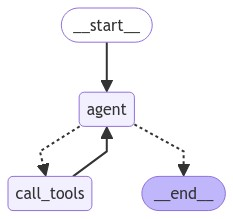

In [5]:
from IPython.display import Image, display

display(Image(human_feedback_graph.get_graph().draw_mermaid_png()))

In [6]:
from langchain.schema import HumanMessage


inputs = {
    "messages": [
        HumanMessage(
            content="Count the lines of all python notebooks in the current directory. Use simple shell commands."
        )
    ]
}

In [7]:
for chunk in human_feedback_graph.stream(inputs):
    for state in chunk.values():
        for message in state["messages"]:
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  terminal (call_SuEUgbd5cLYU2OW4okaTlTP7)
 Call ID: call_SuEUgbd5cLYU2OW4okaTlTP7
  Args:
    commands: find . -name '*.ipynb' -exec jq -r '.cells[] | select(.cell_type == "code") | .source | length' {} + | awk '{s+=$1} END {print s}'


/Users/lorenz/code/langchain_agents/.venv/lib/python3.11/site-packages/langchain_community/tools/shell/tool.py:32: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['find . -name \'*.ipynb\' -exec jq -r \'.cells[] | select(.cell_type == "code") | .source | length\' {} + | awk \'{s+=$1} END {print s}\'']
================================= Tool Message =================================
Name: terminal

find: jq: No such file or directory


================================== Ai Message ==================================
Tool Calls:
  terminal (call_jkxTDyCv0MemxWV8Yqo2kMv9)
 Call ID: call_jkxTDyCv0MemxWV8Yqo2kMv9
  Args:
    commands: find . -name '*.ipynb' -exec python3 -c "import json; f=open('{}.ipynb'); d=json.load(f); print(sum(len(cell['source']) for cell in d['cells'] if cell['cell_type'] == 'code'))" \; | awk '{s+=$1} END {print s}'


/Users/lorenz/code/langchain_agents/.venv/lib/python3.11/site-packages/langchain_community/tools/shell/tool.py:32: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['find . -name \'*.ipynb\' -exec python3 -c "import json; f=open(\'{}.ipynb\'); d=json.load(f); print(sum(len(cell[\'source\']) for cell in d[\'cells\'] if cell[\'cell_type\'] == \'code\'))" \\; | awk \'{s+=$1} END {print s}\'']
================================= Tool Message =================================
Name: terminal

Traceback (most recent call last):
  File "<string>", line 1, in <module>
FileNotFoundError: [Errno 2] No such file or directory: './07_checkpoints.ipynb.ipynb'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
FileNotFoundError: [Errno 2] No such file or directory: './08_memory.ipynb.ipynb'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
FileNotFoundError: [Errno 2] No such file or directory: './03_rag_basics.ipynb.ipynb'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
FileNotFoundError: [Errno 2] No such file or directory: './09_agent_with_sql_toolkit.ipynb.ipynb'
Trace

Das hat funktioniert

Allerdings muss nun unsere App den GraphState und alle Objekte so lange im Memory behalten, bis ein Nutzer endlich die Rückfrage beantwortet. Asynchron ist das ganz schön blöd.

## Lösung 2. LangGraph- Checkpoints

Checkpoints sind ein essentieller Baustein von Langgraph. Bis jetzt haben wir noch nichts davon mitbekommen. Was tun Checkpoints und wozu brauchen wir die?

Weil das Konzept für eine reale App mit realen Nutzern sehr schnell relevant wird, erläutern wir es hier grob.

Wenn eine LangGraph-App mit einem Knoten fertig ist und nachschaut, wohin sie jetzt weiterhüpft (zu welchem Knoten), speichert sie erst einmal den State (und noch andere Dinge) in einen Checkpoint. Das passiert alles in einem kleinen Memory-Objekt und muss uns nicht weiter interessieren. Der nächste Knoten liest dann aus dem Checkpoint des letzten Knoten aus und setzt daran an. Dieses Memory-Objekt ist allerdings volatil und wird gelöscht, nachdem der Graph fertig durchgelaufen ist.

Man kann aber auch den State über Graph invokations hinweg persistieren. Z.B. in SQL, Redis, etc...

Was bringt das?

Nun kann ein Nutzer eine App, die ihm zu lange braucht, terminieren. Bisher abgelaufene Zwischenstände gehen nicht verloren. Er kann die App dann entweder neu starten oder auf dem letzten Zwischenstand aufsetzen.
Man kann der App befehlen, vor einem bestimmten Knoten immer zu terminieren. Der Zwischenstand speichert sich automatisch und der Nutzer muss dann die App erneut dort aufrufen (Das bauen wir jetzt).
Man kann verteilte Systeme bauen, in denen Komponenten ihren Arbeitstand untereinander mittels der Datenbank austauschen.
Man kann die Checkpoints auch für die Chathistory verwenden. Damit hat man dann einen Chatbot mit Gedächtnis.


In [8]:
def unsafe_call_tools(state):
    last_message = state["messages"][-1]
    return {"messages": tool_executor.batch(last_message.tool_calls)}


def should_continue(state) -> Literal["action", END]:  # type: ignore
    return "action" if state["messages"][-1].tool_calls else END

### Jetzt kompilieren wir erneut

Diesmal mit

unsafe_execute_tools
Checkpointer
Interrupt vor der "action"-Node


In [9]:
# Wir nehmen hier einfach den In-Memory Checkpointer und keine umständliche Datenbank
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_builder = StateGraph(AgentState)

graph_builder.add_node("agent", agent)
graph_builder.add_node("action", unsafe_call_tools)
graph_builder.set_entry_point("agent")
graph_builder.add_conditional_edges("agent", should_continue)
graph_builder.add_edge("action", "agent")

checkpoint_agent_executor = graph_builder.compile(
    checkpointer=memory, interrupt_before=["action"]
)

In [10]:
config = {"configurable": {"thread_id": "2"}}
for chunk in checkpoint_agent_executor.stream(inputs, config):
    for state in chunk.values():
        for message in state["messages"]:
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  terminal (call_rm2K4l7QDR1tQoJaxA7DB5pY)
 Call ID: call_rm2K4l7QDR1tQoJaxA7DB5pY
  Args:
    commands: find . -name '*.ipynb' -exec jq '.cells | map(select(.cell_type == "code")) | map(.source | length) | add' {} \; | awk '{s+=$1} END {print s}'


#### Oh, jetzt hat er tatsächlich abgebrochen. Mal sehen, was der State ist:


In [11]:
current_state = checkpoint_agent_executor.get_state(config)
for message in current_state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

Count the lines of all python notebooks in the current directory. Use simple shell commands.
================================== Ai Message ==================================
Tool Calls:
  terminal (call_rm2K4l7QDR1tQoJaxA7DB5pY)
 Call ID: call_rm2K4l7QDR1tQoJaxA7DB5pY
  Args:
    commands: find . -name '*.ipynb' -exec jq '.cells | map(select(.cell_type == "code")) | map(.source | length) | add' {} \; | awk '{s+=$1} END {print s}'


#### Wir können auch sehen, was die nächste Node im Flow wäre.


In [12]:
current_state.next

('action',)

#### Weiter ausführen geht mit None


In [13]:
for chunk in checkpoint_agent_executor.stream(None, config):
    for state in chunk.values():
        for message in state["messages"]:
            message.pretty_print()

Executing command:
 ['find . -name \'*.ipynb\' -exec jq \'.cells | map(select(.cell_type == "code")) | map(.source | length) | add\' {} \\; | awk \'{s+=$1} END {print s}\'']


/Users/lorenz/code/langchain_agents/.venv/lib/python3.11/site-packages/langchain_community/tools/shell/tool.py:32: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


================================= Tool Message =================================
Name: terminal

find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
find: jq: No such file or directory
fin

In [14]:
current_state = checkpoint_agent_executor.get_state(config)
current_state.next

('action',)

## ✅ Aufgabe

### State modifizieren


In [15]:
config = {"configurable": {"thread_id": "17"}}
for chunk in checkpoint_agent_executor.stream(inputs, config):
    for state in chunk.values():
        for message in state["messages"]:
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  terminal (call_w67F6CVKN5TUFJic0FfV9MOJ)
 Call ID: call_w67F6CVKN5TUFJic0FfV9MOJ
  Args:
    commands: find . -name '*.ipynb' -exec jq -r '.cells[] | select(.cell_type == "code") | .source | .[]' {} \; | wc -l


In [16]:
current_state = checkpoint_agent_executor.get_state(config)
current_state.values

{'messages': [HumanMessage(content='Count the lines of all python notebooks in the current directory. Use simple shell commands.', id='2ecf0d10-8aa0-4b99-b1cb-b2ecc731c919'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_w67F6CVKN5TUFJic0FfV9MOJ', 'function': {'arguments': '{"commands":"find . -name \'*.ipynb\' -exec jq -r \'.cells[] | select(.cell_type == \\"code\\") | .source | .[]\' {} \\\\; | wc -l"}', 'name': 'terminal'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f905cf32a9'}, id='run-ae0b5dcd-9996-4eba-a4d2-505d40b0fdd9-0', tool_calls=[{'name': 'terminal', 'args': {'commands': 'find . -name \'*.ipynb\' -exec jq -r \'.cells[] | select(.cell_type == "code") | .source | .[]\' {} \\; | wc -l'}, 'id': 'call_w67F6CVKN5TUFJic0FfV9MOJ', 'type': 'tool_call'}])]}

### Wir überschreiben jetzt einfach das Terminal Tool Call Argument im State...


In [17]:
new_tool_call = "echo 'YOUR CREATIVE ECHO MESSAGE GOES HERE'"

current_state.values["messages"][-1].tool_calls[0]["args"]["commands"] = [new_tool_call]

checkpoint_agent_executor.update_state(config, current_state.values)

checkpoint_agent_executor.get_state(config).values

{'messages': [HumanMessage(content='Count the lines of all python notebooks in the current directory. Use simple shell commands.', id='2ecf0d10-8aa0-4b99-b1cb-b2ecc731c919'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_w67F6CVKN5TUFJic0FfV9MOJ', 'function': {'arguments': '{"commands":"find . -name \'*.ipynb\' -exec jq -r \'.cells[] | select(.cell_type == \\"code\\") | .source | .[]\' {} \\\\; | wc -l"}', 'name': 'terminal'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f905cf32a9'}, id='run-ae0b5dcd-9996-4eba-a4d2-505d40b0fdd9-0', tool_calls=[{'name': 'terminal', 'args': {'commands': ["echo 'YOUR CREATIVE ECHO MESSAGE GOES HERE'"]}, 'id': 'call_w67F6CVKN5TUFJic0FfV9MOJ', 'type': 'tool_call'}])]}

In [18]:
for chunk in checkpoint_agent_executor.stream(None, config):
    for state in chunk.values():
        for message in state["messages"]:
            message.pretty_print()

Executing command:
 ["echo 'YOUR CREATIVE ECHO MESSAGE GOES HERE'"]
================================= Tool Message =================================
Name: terminal

YOUR CREATIVE ECHO MESSAGE GOES HERE



/Users/lorenz/code/langchain_agents/.venv/lib/python3.11/site-packages/langchain_community/tools/shell/tool.py:32: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


================================== Ai Message ==================================
Tool Calls:
  terminal (call_5GIOMEORyKSZm0DYthndDIi9)
 Call ID: call_5GIOMEORyKSZm0DYthndDIi9
  Args:
    commands: ['find . -name \'*.ipynb\' -exec jq -r \'.cells[] | select(.cell_type == "code") | .source | length\' {} + | awk \'{s+=$1} END {print s}\'']
